In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

- In this introductory example, you will see how to use the :code:`spikeinterface` to perform a full electrophysiology analysis.
- We will first create some simulated data, and we will then perform some pre-processing, run a couple of spike sorting algorithms, inspect and validate the results, export to Phy, and compare spike sorters.


In [2]:
import os
import pickle
import _pickle as cPickle
import glob
import warnings
import imp
import shutil

/tmp/ipykernel_57549/868811323.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
from collections import defaultdict
import time
import json
from datetime import datetime

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as sp

import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy

In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import mountainsort5 as ms5

In [11]:
from tempfile import TemporaryDirectory
from mountainsort5.util import create_cached_recording

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [12]:
import spikeinterface.full as si

In [13]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 0: Loading in the Probe

- Reading in the probe information into Spike interface and plotting the probe

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from probeinterface import Probe

# Define grid positions as per the given layout
grid_positions = np.array([
    [15, 19, 8, 20],
    [14, 18, 9, 21],
    [13, 17, 10, 22],
    [12, 16, 11, 23]
])

# Define channel coordinates
channel_coordinates = {
    15: (-1.5,  1.5), 19: (-0.5,  1.5), 8:  (0.5,  1.5), 20: (1.5,  1.5),
    14: (-1.5,  0.5), 18: (-0.5,  0.5), 9:  (0.5,  0.5), 21: (1.5,  0.5),
    13: (-1.5, -0.5), 17: (-0.5, -0.5), 10: (0.5, -0.5), 22: (1.5, -0.5),
    12: (-1.5, -1.5), 16: (-0.5, -1.5), 11: (0.5, -1.5), 23: (1.5, -1.5)
}

# Convert grid positions to spatial coordinates
positions = np.zeros((16, 2))
for i, channel in enumerate(grid_positions.flatten()):
    positions[i] = channel_coordinates[channel]  # Assign coordinates

# Scale the positions (assuming micrometers for ProbeInterface)
positions *= 50  # Convert mm to µm (optional scaling)

# Create probe object
probe_object = Probe(ndim=2, si_units='um')
probe_object.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 5})
probe_object.create_auto_shape(probe_type='tip')



In [121]:
n_channels = 16
# probe_object.set_device_channel_indices(grid_positions.flatten()) 
probe_object.set_device_channel_indices(np.arange(n_channels))  # Ensures proper mapping

In [122]:
probe_3d = probe_object.to_3d(axes='xy')
print(probe_object.contact_positions.shape)
print(probe_3d.contact_positions.shape)

(16, 2)
(16, 3)


In [123]:
df = probe_3d.to_dataframe()
df[['x', 'y', 'z']]

,x,y,z
0,-75.0,75.0,0.0
1,-25.0,75.0,0.0
2,25.0,75.0,0.0
3,75.0,75.0,0.0
4,-75.0,25.0,0.0
5,-25.0,25.0,0.0
6,25.0,25.0,0.0
7,75.0,25.0,0.0
8,-75.0,-25.0,0.0
9,-25.0,-25.0,0.0


(<mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x74af6f630a90>,
 <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x74af6f630df0>)

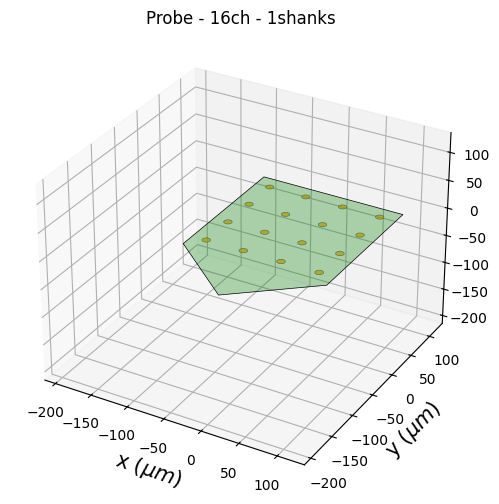

In [124]:
plot_probe(probe_3d)

In [125]:
# probe_object.get_global_contact_ids()

In [126]:
# probe_object.get_global_device_channel_indices()

- Creating a dictionary of all the variables in the probe file

In [127]:
if 'probe_parameters' in locals():
    probe_dict = defaultdict(dict)
    for attribute in dir(probe_parameters):
        # Removing built in attributes
        if not attribute.startswith("__"): 
            probe_dict[attribute] = getattr(probe_parameters, attribute)

In [128]:
if "probe_dict" in locals():
    for key, value in probe_dict.items():
        print("{}: {}".format(key, value))

- Loading in the data

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- We are inputting the electrophsiology recording data with probe information. This should have been created in the prevous notebook in a directory created by Spike Interface. If you had already read in your own electrophsiology recording data with probe information with a different way, then follow these instructions.
    - If you want to use a different directory, then you must either:
        - Change `glob.glob({./path/to/with/*/recording_raw})` to the directory that you have the directories created from Spikeinterface. You can use a wildcard if you have multiple folders. You would replace `{./path/to/with/*/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.
        - Or change `(file_or_folder_or_dict={./path/to/recording_raw})`. You would replace `{./path/to/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.

In [74]:
all_recording_files = sorted(glob.glob('./data/0311/**/*.rhd', recursive=True))

In [75]:
all_recording_files = [file_path for file_path in all_recording_files if "copies" not in file_path]

In [76]:
all_recording_files

['./data/0311/001_250311_170034/001_250311_170034.rhd',
 './data/0311/002_250311_170122/002_250311_170122.rhd',
 './data/0311/003_250311_170340/003_250311_170340.rhd',
 './data/0311/003_250311_170340/003_250311_170441.rhd',
 './data/0311/004_250311_170552/004_250311_170552.rhd',
 './data/0311/004_250311_170632/004_250311_170632.rhd',
 './data/0311/005_250311_170906/005_250311_170906.rhd',
 './data/0311/005_250311_170906/005_250311_171006.rhd',
 './data/0311/006_250311_171137/006_250311_171137.rhd',
 './data/0311/007_250311_171229/007_250311_171229.rhd',
 './data/0311/007_250311_171229/007_250311_171329.rhd',
 './data/0311/008_250311_172829/008_250311_172829.rhd',
 './data/0311/009_250311_173306/009_250311_173306.rhd',
 './data/0311/009_250311_173306/009_250311_173406.rhd',
 './data/0311/010_250311_173624/010_250311_173624.rhd',
 './data/0311/011_250311_173742/011_250311_173742.rhd',
 './data/0311/013_250311_180302/013_250311_180302.rhd',
 './data/0311/014_250311_180524/014_250311_18052

# Part 2: Sorting

In [85]:
import numpy as np
import pandas as pd

# Given center coordinate in mm
# center_ml, center_ap, center_vd = 3.0, -2.5, -1.5
center_ml, center_ap, center_vd = 0, 0, 0

# spacing = 0.5  # Distance between electrodes
spacing = 1  # Distance between electrodes


# # Define grid positions (assuming a 4x4 layout)
# grid_positions = np.array([
#     [15, 11, 6, 2],
#     [16, 12, 7, 3],
#     [17, 13, 8, 4],
#     [18, 14, 9, 5]
# ])

# Define grid positions (assuming a 4x4 layout)
grid_positions = np.array([
    [15, 19, 8, 20],
    [14, 18, 9, 21],
    [13, 17, 10, 22],
    [12, 16, 11, 23]
])

# Calculate coordinates
channel_coords = []
for row_idx, row in enumerate(grid_positions):
    for col_idx, channel in enumerate(row):
        ml = center_ml + (col_idx - 1.5) * spacing  # Adjusting for 4x4 center
        ap = center_ap - (row_idx - 1.5) * spacing  # Adjusting for row shift
        channel_coords.append((channel, ml, ap, center_vd))

# Convert to DataFrame
df_coords = pd.DataFrame(channel_coords, columns=["Channel", "ML (mm)", "AP (mm)", "VD (mm)"])
print(df_coords)

df_coords["Channel"] = df_coords["Channel"].astype(int).astype(str)

# Save to CSV
df_coords.to_csv("channel_coordinates.csv", index=False)


    Channel  ML (mm)  AP (mm)  VD (mm)
0        15     -1.5      1.5        0
1        19     -0.5      1.5        0
2         8      0.5      1.5        0
3        20      1.5      1.5        0
4        14     -1.5      0.5        0
5        18     -0.5      0.5        0
6         9      0.5      0.5        0
7        21      1.5      0.5        0
8        13     -1.5     -0.5        0
9        17     -0.5     -0.5        0
10       10      0.5     -0.5        0
11       22      1.5     -0.5        0
12       12     -1.5     -1.5        0
13       16     -0.5     -1.5        0
14       11      0.5     -1.5        0
15       23      1.5     -1.5        0


In [86]:
denominator = 35

In [87]:
# Create channel positions dictionary
ch_pos = {str(row["Channel"]): [row["ML (mm)"] / denominator, row["AP (mm)"] / denominator, row["VD (mm)"] / denominator] for _, row in df_coords.iterrows()}

/tmp/ipykernel_57549/1714244572.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  montage.plot(kind="topomap", show=True)


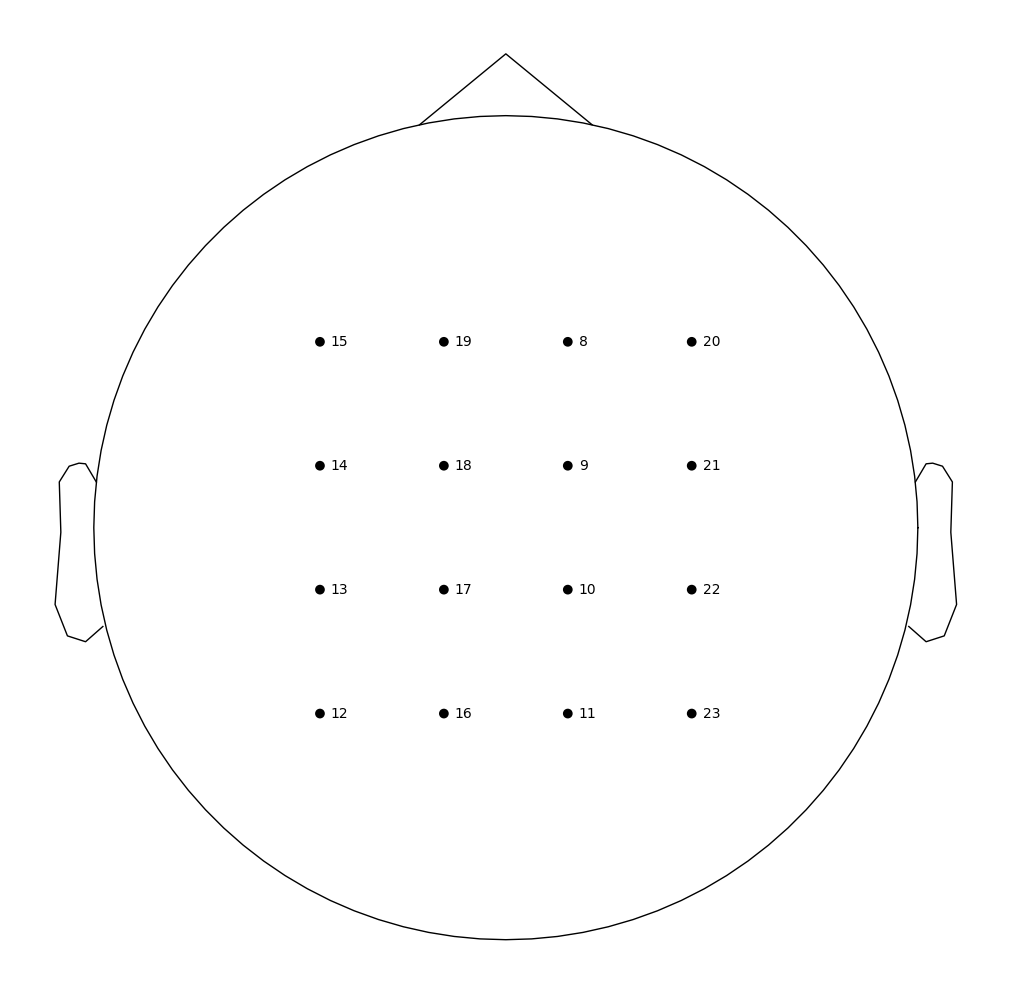

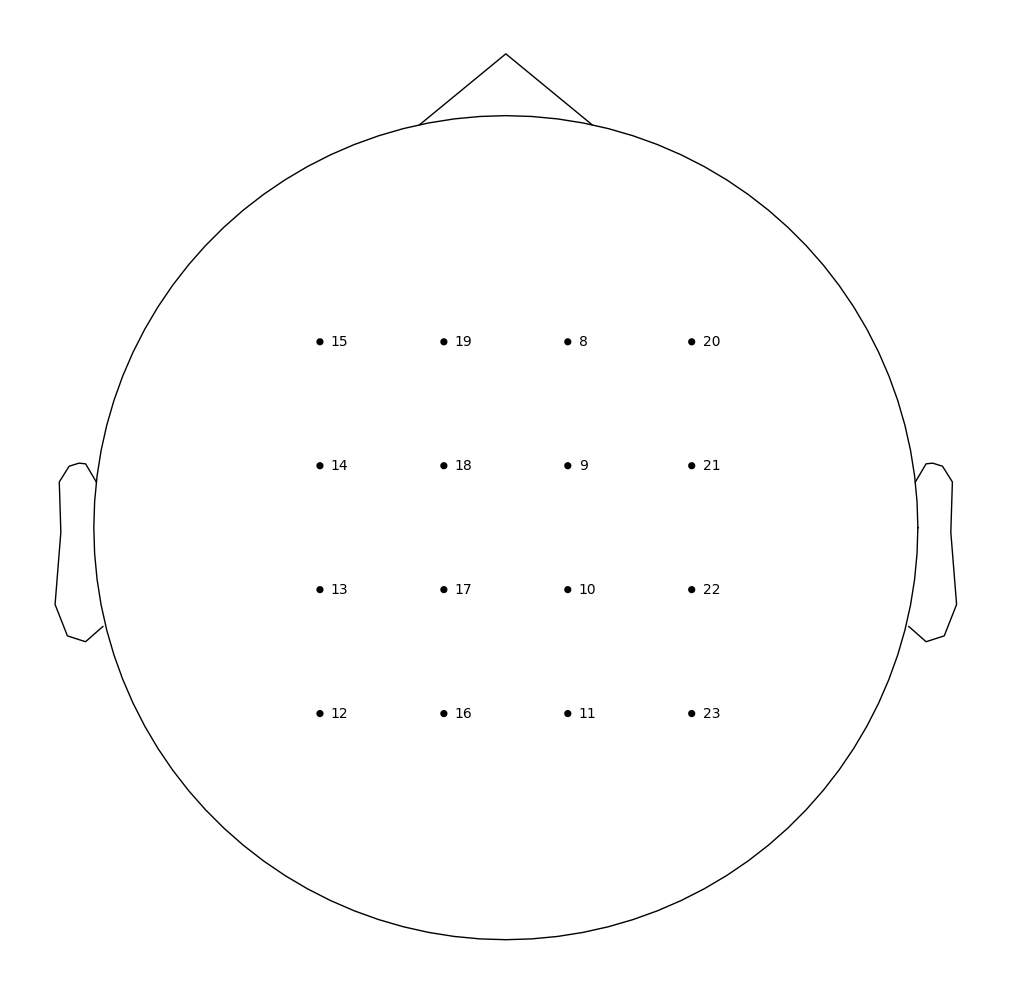

In [88]:
# Create montage (coord_frame='unknown' for non-human data)
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame="unknown")

# Visualize the montage
montage.plot(kind="topomap", show=True)

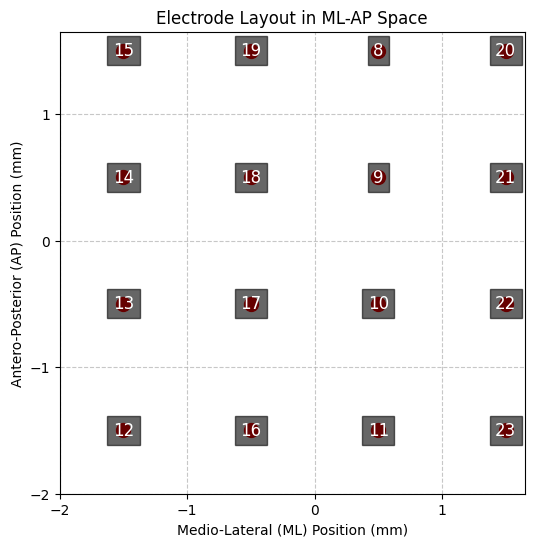

In [89]:
# Plot the 2D coordinates (ML vs AP) in Matplotlib
fig, ax = plt.subplots(figsize=(6, 6))

# Iterate over each channel and plot it
for _, row in df_coords.iterrows():
    ax.scatter(row["ML (mm)"], row["AP (mm)"], color='red', s=100)
    ax.text(row["ML (mm)"], row["AP (mm)"], str(int(row["Channel"])), fontsize=12,
            ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.6))

# Formatting the plot
ax.set_xlabel("Medio-Lateral (ML) Position (mm)")
ax.set_ylabel("Antero-Posterior (AP) Position (mm)")
ax.set_title("Electrode Layout in ML-AP Space")
ax.set_xticks(np.arange(df_coords["ML (mm)"].min() - 0.5, df_coords["ML (mm)"].max() + 0.5, spacing))
ax.set_yticks(np.arange(df_coords["AP (mm)"].min() - 0.5, df_coords["AP (mm)"].max() + 0.5, spacing))
ax.grid(True, linestyle='--', alpha=0.7)
plt.gca()  # AP coordinates usually decrease in the posterior direction

# Show plot
plt.savefig("Electrode_Layout.png")

In [90]:
# Load the background Python functions that allow for data loading and plotting
%run importrhdutilities.py

<Figure size 1000x600 with 0 Axes>

In [91]:
# Re-import necessary libraries after execution state reset
import os
import numpy as np
import pandas as pd
import mne

initial_offset = 5

# Initialize a list to store DataFrame rows
eeg_data_records = []

# Processing each file
for file_path in eeg_files[:]:  # or eeg_files[5:] depending on your choice
    file_base = os.path.splitext(os.path.basename(file_path))[0]

    try:
        # Extract numeric recording number from file name (e.g., "006_250121_175954" → 6)
        recording_number = int(file_base.split('_')[0])

        # # Find the matching row in the DataFrame
        # row = recording_notes[recording_notes["# of Test"] == recording_number]

        # if row.empty:
        #     print(f"No stimulation data for recording {recording_number}")
        #     stimulation_times = None
        # else:
        #     # Extract tuple list
        #     stimulation_times = row["Stimulation Tuples"].values[0]

        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [
            d["native_channel_name"].replace("A-0", "").replace("B-0", "")
            for d in result["amplifier_channels"]
        ]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if str(int(ch)) in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [str(int(all_channels[i])) for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(
            ch_names=filtered_channel_list,
            sfreq=sampling_rate,
            ch_types='eeg'
        )
        raw = mne.io.RawArray(filtered_data, info)

        # Crop the first and last 5 seconds
        duration = raw.times[-1]  # Total duration of the recording
        if duration > 30:  # Ensure at least 10 seconds remain after cropping
            raw.crop(tmin=initial_offset, tmax=duration - 10)
        else:
            print(f"File {file_base} too short after cropping.")
            continue

        # Apply montage
        raw.set_montage(montage)

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Store all channel EEG traces together in one DataFrame row per recording
        eeg_data_records.append({
            "Recording Name": file_base,
            "Channels": filtered_channel_list,
            "Filtered EEG Trace": data,  # Store trace as a NumPy array
            "Sampling Rate": sampling_rate,
            # "Stimulation Times": stimulation_times,
            # "Recording Notes": row["Action"].values[0],
            "Time Points": times
        })

    except Exception as e:
        print(f"Error processing {file_base}: {e}")
        break
        continue

# Convert to DataFrame
eeg_df = pd.DataFrame(eeg_data_records)


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 12.382 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.3 seconds
Creating RawArray with float64 data, n_channels=16, n_times=371456
    Range : 0 ... 371455 =      0.000 ...    12.382 secs
Ready.
File 001_250311_170034 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.5 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1800064
    Range : 0 ... 1800063 =      0.000 ...    60.002 secs
Ready.


/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)



Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 1.668 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=50048
    Range : 0 ... 50047 =      0.000 ...     1.668 secs
Ready.
File 003_250311_170441 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital in

/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.9 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1800064
    Range : 0 ... 1800063 =      0.000 ...    60.002 secs
Ready.


/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)



Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 2.351 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=70528
    Range : 0 ... 70527 =      0.000 ...     2.351 secs
Ready.
File 005_250311_171006 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital in

/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.6 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1800064
    Range : 0 ... 1800063 =      0.000 ...    60.002 secs
Ready.


/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)



Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 3.136 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=94080
    Range : 0 ... 94079 =      0.000 ...     3.136 secs
Ready.
File 007_250311_171329 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital in

/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.8 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1800064
    Range : 0 ... 1800063 =      0.000 ...    60.002 secs
Ready.


/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)



Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 1.498 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=44928
    Range : 0 ... 44927 =      0.000 ...     1.498 secs
Ready.
File 009_250311_173406 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital in

/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.6 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1784576
    Range : 0 ... 1784575 =      0.000 ...    59.486 secs
Ready.


/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)



Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 49.929 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.3 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1497856
    Range : 0 ... 1497855 =      0.000 ...    49.928 secs
Ready.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output c

/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.4 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1773312
    Range : 0 ... 1773311 =      0.000 ...    59.110 secs
Ready.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 60.002 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...


/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 2.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1800064
    Range : 0 ... 1800063 =      0.000 ...    60.002 secs
Ready.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 2.487 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=7

/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


File 015_250311_180809 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 52.932 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.9 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1587968
    Range : 0 ... 1587967 =      0.000 ...    52.932 secs
Ready.


/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)



Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 19.755 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.5 seconds
Creating RawArray with float64 data, n_channels=16, n_times=592640
    Range : 0 ... 592639 =      0.000 ...    19.755 secs
Ready.
File 017_250311_182149 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.4 seconds
Creating RawArray with float64 data, n_channels=16, n_times=606976
    Range : 0 ... 606975 =      0.000 ...    20.233 secs
Ready.
File 019_250311_182453 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 30.438 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.5 seconds
Creating RawArray with float64 data, n_channels=16, n_times=913152
    Ra

/tmp/ipykernel_57549/532059136.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


In [94]:
eeg_df["Filtered EEG Trace"].iloc[0]

array([[  11.115,  -24.375,   13.65 , ...,   16.965,   42.12 ,   23.79 ],
       [ 384.54 ,  358.215,  349.44 , ..., -659.685, -618.93 , -621.465],
       [-306.735, -315.9  , -329.94 , ...,  226.395,   86.19 ,  120.315],
       ...,
       [-250.77 , -208.65 , -204.945, ..., -301.665, -268.905, -279.63 ],
       [-330.915, -304.98 , -303.615, ...,  232.635,  183.885,  222.69 ],
       [ 369.915,  369.72 ,  347.295, ..., -157.17 , -128.31 , -142.935]])

In [97]:
recording = se.NumpyRecording(traces_list=[eeg_df["Filtered EEG Trace"].iloc[0].T], sampling_frequency=30000)
print(recording)

NumpyRecording: 16 channels - 30.0kHz - 1 segments - 472,368 samples - 15.75s - float64 dtype 
                57.66 MiB


In [98]:
eeg_df.head()

,Recording Name,Channels,Filtered EEG Trace,Sampling Rate,Time Points
0,002_250311_170122,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...","[[11.115, -24.375, 13.65, -3.12, -2.145, 6.435...",30000.0,"[0.0, 3.3333333333333335e-05, 6.66666666666666..."
1,003_250311_170340,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...","[[-158.925, -155.22, -151.32, -147.225, -143.3...",30000.0,"[0.0, 3.3333333333333335e-05, 6.66666666666666..."
2,004_250311_170632,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...","[[49.53, 44.655, 43.29, 36.075, 43.485, 35.1, ...",30000.0,"[0.0, 3.3333333333333335e-05, 6.66666666666666..."
3,005_250311_170906,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...","[[31.59, 44.07, 32.565, 26.715, 39.195, 23.400...",30000.0,"[0.0, 3.3333333333333335e-05, 6.66666666666666..."
4,006_250311_171137,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...","[[-5.46, -1.9500000000000002, 1.365, 12.870000...",30000.0,"[0.0, 3.3333333333333335e-05, 6.66666666666666..."


In [132]:
spike_sorted_object

NameError: name 'spike_sorted_object' is not defined

In [134]:
recording_cached

BinaryRecordingExtractor: 16 channels - 30.0kHz - 1 segments - 463,152 samples - 15.44s 
                          float32 dtype - 28.27 MiB
  file_paths: ['/tmp/tmp_fjoawcp/recording.dat']

In [135]:
successful_files = [] 
failed_files = []

for index, row in eeg_df.iterrows():
   
    recording_basename = row["Recording Name"]
    recording_output_directory = "./spike_sorting/{}".format(recording_basename)
    os.makedirs(recording_output_directory, exist_ok=True)

    print("Output directory: {}".format(recording_output_directory))
    
    try:
        with open('successful_files.txt', "r") as myfile:
            if recording_basename in myfile.read():
                warnings.warn("""Directory already exists for: {}.
                              Either continue on if you are satisfied with the previous run 
                              or delete the directory and run this cell again""".format(recording_basename))
                continue
    except:
        pass
    
    try:
        trodes_recording = se.NumpyRecording(traces_list=[row["Filtered EEG Trace"].T], sampling_frequency=30000)     
        trodes_recording = trodes_recording.set_probes(probe_object)

        child_spikesorting_output_directory = os.path.join(recording_output_directory,"ss_output")
               
        start = time.time()
        # Make sure the recording is preprocessed appropriately
        # lazy preprocessing
        print("Running bandpass filter")
        recording_filtered = sp.bandpass_filter(trodes_recording, freq_min=300, freq_max=6000, dtype=np.float32)

        print("Running whitening")
        recording_preprocessed: si.BaseRecording = sp.whiten(recording_filtered, dtype=np.float32)
        
        with TemporaryDirectory() as tmpdir:
            # cache the recording to a temporary directory for efficient reading
            print("Caching the recording")
            recording_cached = create_cached_recording(recording_preprocessed, folder=tmpdir)
            recording_cached = recording_cached.set_probes(probe_object)
            recording_cached.annotate(is_filtered=True)

            print("Spike sorting")
            spike_sorted_object = ms5.sorting_scheme2(
                recording=recording_cached,
                sorting_parameters=ms5.Scheme2SortingParameters(
                    detect_sign=0,
                    phase1_detect_channel_radius=300,
                    detect_channel_radius=300,
                # other parameters...
                )
            )
            
            assert isinstance(spike_sorted_object, si.BaseSorting)
            
            shutil.rmtree(child_spikesorting_output_directory, ignore_errors=True)
            spike_sorted_object.save(folder=child_spikesorting_output_directory)

            sw.plot_rasters(spike_sorted_object)
            plt.title(recording_basename)
            plt.ylabel("Unit IDs")
            
            plt.savefig(os.path.join(recording_output_directory, "{}_raster_plot.png".format(recording_basename)))
            plt.close()
            
            print("Exporting waveforms")
            waveform_output_directory = os.path.join(recording_output_directory, "waveforms")
            we_spike_sorted = si.extract_waveforms(
                recording=recording_cached, 
                sorting=spike_sorted_object, 
                folder=waveform_output_directory,
                ms_before=1, 
                ms_after=1, 
                progress_bar=True,
                n_jobs=-1, 
                total_memory="8G", 
                overwrite=True,
                max_spikes_per_unit=2000,
                sparse=False)
            
            print("we_spike_sorted is sparse: {}".format(we_spike_sorted.is_sparse()))
            
            print("Saving to phy")
            phy_output_directory = os.path.join(recording_output_directory, "phy")
            export_to_phy(we_spike_sorted, 
                            phy_output_directory,
                            compute_pc_features=True, 
                            compute_amplitudes=True, 
                            remove_if_exists=True)
            
            # edit the params.py file os that it contains the correct realtive path
            params_path = os.path.join(phy_output_directory, "params.py")
            with open(params_path, 'r') as file:
                lines = file.readlines()
            lines[0] = "dat_path = r'./recording.dat'\n"
            with open(params_path, 'w') as file:
                file.writelines(lines)
            
            successful_files.append(recording_file)
            with open('successful_files.txt', "a+") as fd:
                fd.write(f'\n{recording_basename}')                     

    except Exception as e: 
        print(e)


Output directory: ./spike_sorting/002_250311_170122
Running bandpass filter
Running whitening
Caching the recording


write_binary_recording:   0%|          | 0/16 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 15.7456 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 472368
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,

write_binary_recording:   0%|          | 0/46 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 45.00213333333333 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 1350064
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/18 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 17.008533333333332 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 510256
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/46 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 45.00213333333333 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 1350064
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/16 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 15.916266666666667 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 477488
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/46 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 45.00213333333333 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 1350064
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/16 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 15.062933333333334 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 451888
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/46 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 45.00213333333333 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 1350064
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.004 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/16 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 15.916266666666667 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 477488
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/45 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 44.485866666666666 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 1334576
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,

write_binary_recording:   0%|          | 0/35 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 34.928533333333334 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 1047856
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,

write_binary_recording:   0%|          | 0/45 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 44.1104 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 1323312
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12

write_binary_recording:   0%|          | 0/46 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 45.00213333333333 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 1350064
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/38 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 37.93226666666666 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 1137968
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

write_binary_recording:   0%|          | 0/16 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 15.848 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 475440
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

write_binary_recording:   0%|          | 0/16 [00:00<?, ?it/s]

Spike sorting
Using the full recording for training: 15.4384 sec
Running phase 1 sorting
Number of channels: 16
Number of timepoints: 463152
Sampling frequency: 30000 Hz
Channel 0: [-75.  75.]
Channel 1: [-25.  75.]
Channel 2: [25. 75.]
Channel 3: [75. 75.]
Channel 4: [-75.  25.]
Channel 5: [-25.  25.]
Channel 6: [25. 25.]
Channel 7: [75. 25.]
Channel 8: [-75. -25.]
Channel 9: [-25. -25.]
Channel 10: [ 25. -25.]
Channel 11: [ 75. -25.]
Channel 12: [-75. -75.]
Channel 13: [-25. -75.]
Channel 14: [ 25. -75.]
Channel 15: [ 75. -75.]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 300
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,

In [130]:
we_spike_sorted

NameError: name 'we_spike_sorted' is not defined

In [107]:
trodes_recording

NumpyRecording: 16 channels - 30.0kHz - 1 segments - 463,152 samples - 15.44s - float64 dtype 
                56.54 MiB

In [ ]:
raise ValueError()